# 批量归一化从 $0$ 实现

### 归一化 : 
$$
\dfrac{x-\mu}{\sigma
}$$ 

其中 $\mu$ 是均值, $\sigma$ 是标准差

### 批量归一化 : 

在使用批量归一化的时候, 批量的大小设置会显得比以前更重要一些, 批量太小是不太合适的, 比如大小为 $1$ 的批量将学不到任何东西, 因为减去均值之后就已经为 $0$ 了

$$
\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}
$$

$\odot$ 是按照元素相乘, 用 $\mathbf{x} \in \mathcal{B}$ 表示一个来自小批量 $\mathcal{B}$ 的输入, $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本均值, $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本标准差

拉伸参数 $\boldsymbol{\gamma}$ 和偏移参数 $\boldsymbol{\beta}$, 它们的形状与 $\mathbf{x}$ 相同, 这两个参数是一个可以学习的参数

$$
\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}
$$

加入常量 $\epsilon>0$ 是为了保证不会除以 $0$ , 在估计中会产生一个噪声, 实际上这个噪声对网络是有益的

### 全连接层 :

全连接层的输入为 $u$ , 权重为 $\mathbf{W}$ , 偏置为 $\mathbf{b}$ , 激活函数为 $\phi$ , 则批量归一化为 :

$$
\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) )
$$

### 卷积层 : 

同样是在卷积之后, 激活函数之前应用批量归一化

In [2]:
import torch
from torch import nn
import d2l.torch as d2l

$\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \dfrac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon$ , $var$ 是方差, 是 $\dfrac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2$ 这部分

在全连接层中, 求第一个均值是在 $dim=0$ , 意思是对每一个 $feature$ 求均值, 后面那一个求均值也是一样的, $dim=0$ 就表示拍扁 $dim=0$ 的维度

在卷积层中, 对 $dim=0,2,3$ 求平均, 第一维是 $batch\_size$ 或者是 $in\_channel$ 然后第二维是 $out\_channel$ , 对每一个 $feature$ 求均值, 要保持图像的大小不变, 也就是对输出通道的 $m\times p\times q$ 个元素进行归一化

In [3]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled(): # 说明不是在训练模式 
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        if len(X.shape) == 2: # 全连接层 
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True) # 保持形状做广播运算
            var = ((X-mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 -momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

一般来说 $momentum$ 和 $eps$ 不需要修改, 记录 $moving$ 的值方便预测模式中计算

In [4]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gama = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gama, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [5]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.254, train acc 0.905, test acc 0.809
42428.5 examples/sec on cuda:0


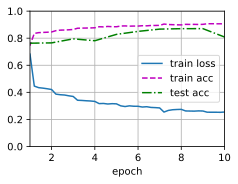

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(), ylim=[0.0, 1.0])

loss 0.201, train acc 0.926, test acc 0.864
42932.8 examples/sec on cuda:0


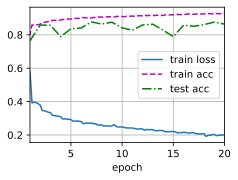

In [8]:
lr, num_epochs, batch_size = 0.3, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.184, train acc 0.931, test acc 0.894
24466.1 examples/sec on cuda:0


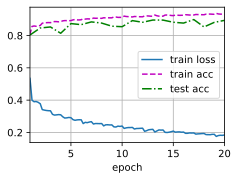

In [9]:
lr, num_epochs, batch_size = 0.3, 20, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.169, train acc 0.937, test acc 0.893
13296.3 examples/sec on cuda:0


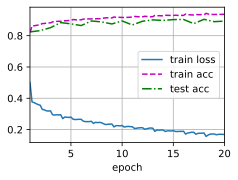

In [10]:
lr, num_epochs, batch_size = 0.3, 20, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

$batch\_size$ 一般设置为 $2$ 的倍速是为了方便于 $GPU$ 的并行计算

降低 $batch\_size$ 以提高模型精度, 老中医的直觉哈哈哈哈哈